# Team Assignment 4
Kikzely Avalos, Mariah Bergquist, Matti Betts, David Aaby

## 1. Project Questions

**How do fatal versus non-fatal shootings impact overall crime rates in different areas of Seattle?**

This question aims to understand the spatial distribution and overall influence of fatal and non-fatal shootings on crime rates in Seattle. By identifying patterns in these incidents, we hope to answer whether certain areas are more affected by fatal versus non-fatal shootings and if they have any influence on crime rates.

**How does a subject's age, race, and gender predict whether or not their crime ended in a fatality?**

This question analyzes the role of demographic factors, age, race ,and gender, and its impact on a shootings outcome. These patterns can answer whether specific groups are more likely to be involved in fatal outcomes, giving us an understanding of the risk factors associated with fatal shootings.

Methods
To answer these questions, we will use Classification methods.

Classification Models (Logistic Regression and Random Forest):

We will use classification models to predict whether a shooting incident results in a fatality. Logistic regression will provide an understanding of the relationship between features and fatality, while a Random Forest model can assess feature importance. These methods will help identify the most significant demographic and situational factors related to fatal outcomes that will help answer the second question.

Confusion Matrix and Performance Metrics:

For each classification model, we will analyze confusion matrices and calculate metrics like precision, recall, and F1-score. These metrics will help evaluate the model’s ability to distinguish between fatal and non-fatal outcomes, answering how well the models can classify incidents accurately. This analysis will inform the impact of fatal versus non-fatal incidents on overall crime rates.

Clustering Analysis (PCA and Temporal Feature Clustering):

We will use clustering techniques based on features like time of day, day of week, or season to identify patterns in incident occurrences. By visualizing the clusters of incidents, we can analyze whether certain types of shootings (fatal or non-fatal) are more common within specific clusters, which could have a relation to overall crime trends in Seattle. This method will primarily answer the first question by highlighting the temporal and potentially spatial patterns associated with crime.

## 2. Methods and Results

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
merged_data = pd.read_csv('Merged_Data 1.csv')

Clustering

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


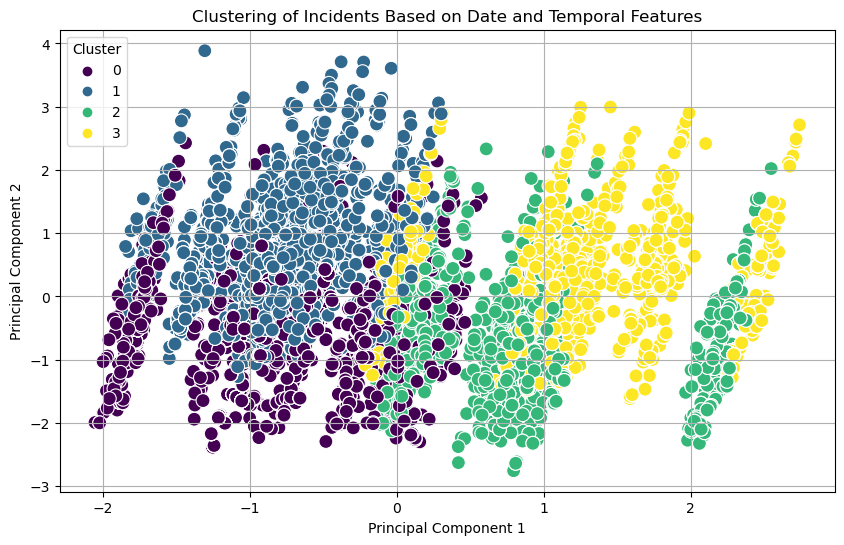

In [102]:
merged_data['Date'] = pd.to_datetime(merged_data['Date'], errors='coerce')
merged_data['Day of Week'] = merged_data['Date'].dt.day_name()
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Day'] = merged_data['Date'].dt.day


features = ['Latitude_x', 'Longitude_x', 'Day of Week', 'Month', 'Disposition']
data = merged_data[features].dropna()
label_encoders = {}
for column in ['Day of Week', 'Disposition']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = data['Cluster']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100)
plt.title('Clustering of Incidents Based on Date and Temporal Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Cluster 1

Location: Centered at latitude 47.622 and longitude -122.333. Day of the Week: Mode is 1 (Monday). Month: Mode is 9 (September). Disposition: Mode is "Justified," suggesting that incidents in this cluster often required actions deemed appropriate and justified. Insight: Cluster 1 includes incidents that happen on Mondays in September and are frequently resolved with a "Justified" outcome, possibly indicating situations where actions were necessary due to heightened risk or more complex scenarios.

Cluster 2

Location: Centered at latitude 47.627 and longitude -122.333. Day of the Week: Mode is 3 (Wednesday). Month: Mode is 1 (January). Disposition: Mode is "Within Policy." Insight: Similar to Cluster 0, Cluster 2 represents incidents occurring on Wednesdays in January and generally resolved according to standard policy, likely reflecting routine incidents during winter.

Cluster 3

Location: Centered around latitude 47.624 and longitude -122.331. Day of the Week: Mode is 5 (Friday). Month: Mode is 1 (January). Disposition: Mode is "Justified." Insight: Cluster 3 appears to represent incidents that occur on Fridays in January, with outcomes often marked as "Justified." This could indicate more complex or higher-risk incidents requiring appropriate action at the end of the week.

Summary Routine (Within Policy) vs. Necessary Actions (Justified): Clusters 0 and 2 predominantly include routine incidents, resolved within policy on Wednesdays in December and January, respectively. Clusters 1 and 3, with "Justified" as the disposition, suggest incidents that required necessary and appropriate responses, possibly indicating more complex situations on Mondays (Cluster 1) and Fridays (Cluster 3). Temporal and Seasonal Patterns: Clusters 0 and 2 capture incidents in winter months (December and January), while Cluster 1 focuses on early fall (September). The "Justified" clusters are spread across Mondays and Fridays, possibly highlighting incidents that require specific action at different times of the week.

These clusters help answer the project question about the impact of fatal versus non-fatal shootings on crime rates by showing distinct temporal patterns in crime occurrences. By examining the characteristics of incidents within each cluster, we can identify if fatal or non-fatal incidents are more frequent in specific clusters. For example, if fatal shootings predominantly fall within Cluster 3, it would suggest that these incidents tend to occur under certain temporal conditions, which could influence crime rates in certain areas or at particular times.

Additionally, this temporal clustering may reveal insights related to the second project question on demographic predictions. If certain demographic groups are more common in a specific cluster, it could suggest that factors like age, race, and gender align with specific time-related patterns of crime, potentially correlating with fatality outcomes. This clustering analysis provides a foundation for deeper exploration into how time-based factors influence both fatal and non-fatal shooting incidents across Seattle, contributing to a more comprehensive understanding of crime dynamics in the city.

Random Forest 

In [112]:
merged_data['Years of SPD Service'] = merged_data['Years of SPD Service'].replace(['< 1', '<1'], 0.5).astype(float)

data_filtered = merged_data[['Officer Disciplined?', 'Years of SPD Service', 'Subject Race', 'Fatal', 'Disposition']].dropna()

X = data_filtered[['Years of SPD Service', 'Subject Race', 'Fatal', 'Disposition']]
y = data_filtered['Officer Disciplined?'].apply(lambda x: 1 if x == 'Yes' else 0)
categorical_features = ['Subject Race', 'Fatal', 'Disposition']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Subject Race', 'Fatal',
                                                   'Disposition'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [115]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)


Model Accuracy: 1.0


The model has perfect accuracy, most likely because the disposition column directly correlates with the officer disciplined column.

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

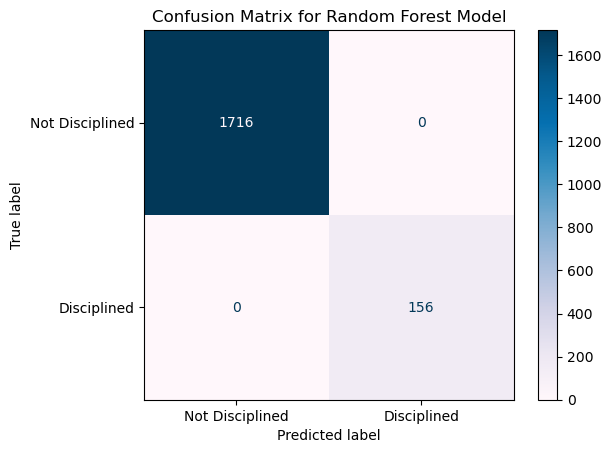

In [125]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Disciplined', 'Disciplined'])
disp.plot(cmap='PuBu')
plt.title("Confusion Matrix for Random Forest Model")
plt.show()


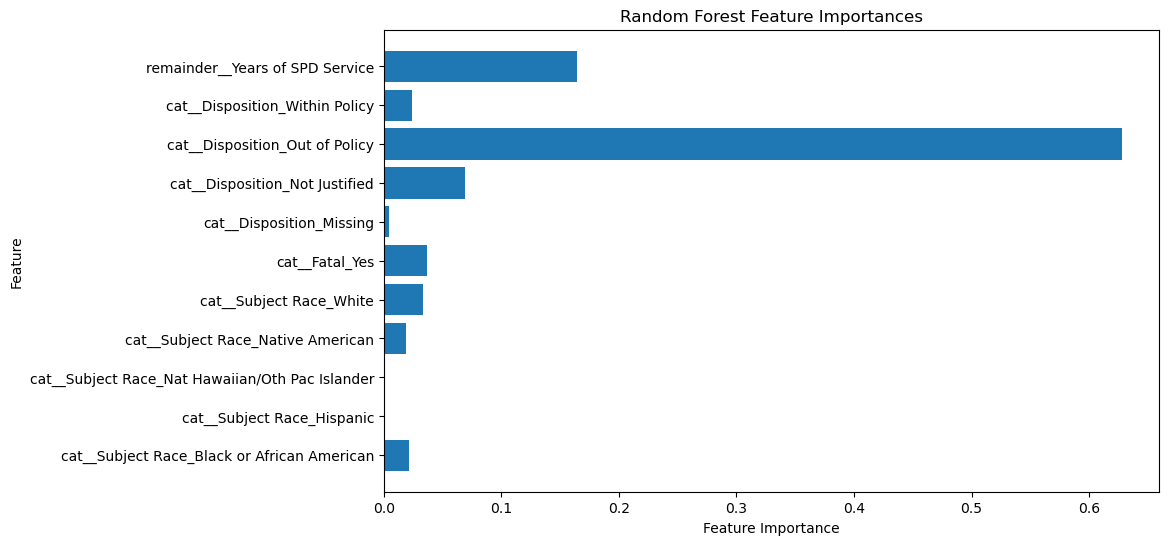

In [128]:
# assess feature importance for my random forest generator, model is too perfect because of disposition.
import matplotlib.pyplot as plt
import numpy as np

feature_importances = pipeline.named_steps['classifier'].feature_importances_
encoded_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), encoded_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()


We can see from the feature importance distribution chart above, Dispisition not justified is extremely important for predicting if an officer is disciplined. Years of SPD service is the second most important future for my random forest classifier.

Since the model is perfect with this disposition column, it is a good indicator of an honest police system that does will discipline an officer if they are not within policy. Next, I built the same model without the disposition column to test other variables.

In [137]:

data_filtered = merged_data[['Officer Disciplined?', 'Years of SPD Service', 'Subject Race', 'Fatal']].dropna()
data_filtered['Years of SPD Service'] = data_filtered['Years of SPD Service'].replace(['< 1', '<1'], 0.5).astype(float)

X = data_filtered[['Years of SPD Service', 'Subject Race', 'Fatal']]
y = data_filtered['Officer Disciplined?'].apply(lambda x: 1 if x == 'Yes' else 0)

In [139]:
categorical_features = ['Subject Race', 'Fatal']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [142]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Subject Race', 'Fatal'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Model Accuracy: 0.9877136752136753


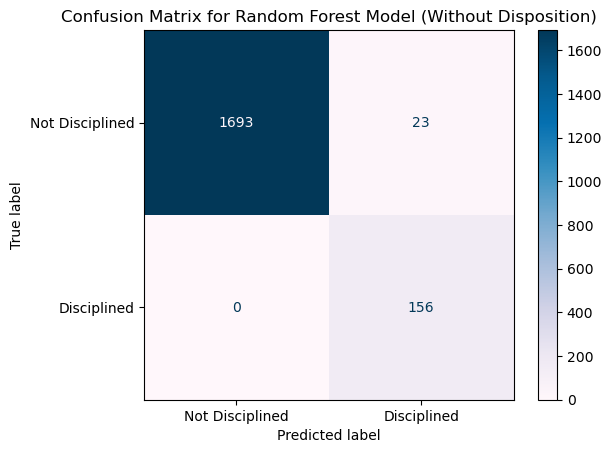

In [144]:
# Confusion matrix without disposition

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Disciplined', 'Disciplined'])
disp.plot(cmap='PuBu')
plt.title("Confusion Matrix for Random Forest Model (Without Disposition)")
plt.show()


This model resulted in high accuracy with 23 false disipline predictions. This could indicate that the other variables ('Years of SPD Service', 'Subject Race', 'Fatal') are strong indicators of if an incident will be within policy.

Overall, the model is highly accurate without the disposition column and perfect with the column included. This tells us that we can predict if an officer will be disciplined with extremely high accuracy with 'Years of SPD Service', 'Subject Race', and 'Fatal' and assume that the officer will be disciplined if the indicent is not within policy.

Random Forest Model with All Features

The first confusion matrix shows high accuracy in predicting both "Disciplined" and "Not Disciplined" outcomes, with no false positives or false negatives. This suggests that the model is very effective at distinguishing between these two categories. However, this result might indicate overfitting, especially given the perfect separation between classes. The feature importance plot shows that the "Disposition_Out of Policy" feature has a significant influence on the model’s predictions, along with other factors like the "Years of SPD Service" and the "Disposition_Not Justified." The focus on disposition highlights how cases outside precinct policy guidelines have a strong influence on the disciplinary outcome, which ties back to the question about fatal versus non-fatal shootings, as some rule violations may be more likely associated with fatal outcomes.

Fatality Predictions Based on Demographic Factors

The feature importance plot also provides information on the relationship between demographic factors and the chance of a crime ending in a fatality. While the "Disposition_Out of Policy" variable is strongly present in the model, smaller contributions from demographic features like "Subject Race" categories suggest that factors such as race might have a minor but noticeable influence on fatality predictions. However, this influence is less significant compared to policy-related features, indicating that demographic factors alone are not the primary determinants of fatal outcomes but may still play a role.

Random Forest Model Excluding Disposition Features

The second confusion matrix without disposition features shows a minor decrease in performance, with a few false positives for the "Not Disciplined" variable. This indicates that policy-related factors, like "Disposition_Out of Policy," are important for accurate classification in this context. Removing these features slightly weakens the model, which shows that following policy has a relationship with disciplinary outcomes. Like the first model with all features, this supports the understanding that not following policy leads to more fatal outcomes. 

Logistic Regression

In [153]:
merged = pd.read_csv('Merged_Data 1.csv', dtype={'Fatal': object})

In [157]:
merged['Fatal'] = merged['Fatal'].map({'Yes': 1, 'No': 0})
merged['Fatal']

0       0
1       0
2       0
3       0
4       0
       ..
9354    1
9355    0
9356    0
9357    0
9358    0
Name: Fatal, Length: 9359, dtype: int64

In [161]:
merged = merged.dropna(subset=['Fatal'])
merged['Fatal'] = merged['Fatal'].astype(int)

In [168]:
features = ['Subject Race', 'Subject Gender', 'Subject Age']
X = merged[features]
y = merged['Fatal']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(X[['Subject Race', 'Subject Gender']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Subject Race', 'Subject Gender']))
X = pd.concat([X, encoded_df], axis=1)
X = X.drop(['Subject Race', 'Subject Gender'], axis=1)
X['Subject Age'] = pd.to_numeric(X['Subject Age'], errors='coerce')  # Convert to numeric, 'Unknown' becomes NaN
X['Subject Age'] = X['Subject Age'].fillna(X['Subject Age'].median())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [172]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

           0       0.53      0.24      0.33       743
           1       0.63      0.86      0.73      1129

    accuracy                           0.62      1872
   macro avg       0.58      0.55      0.53      1872
weighted avg       0.59      0.62      0.57      1872

[[180 563]
 [157 972]]


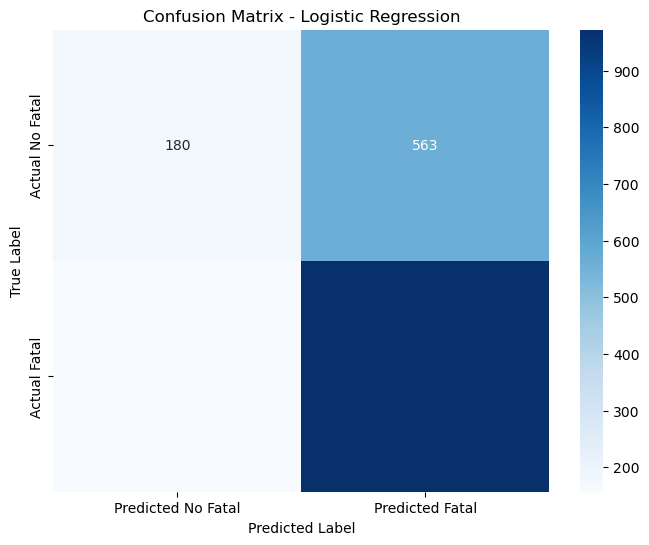

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted No Fatal', 'Predicted Fatal'],
            yticklabels=['Actual No Fatal', 'Actual Fatal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

The confusion matrix shows its strengths and weaknesses in its ability to classify fatal vs non-fatal outcomes. The model performs well in identifying fatal cases, with high recall and moderate precision, reflected by a significant amount of true positives (980) and fewer false negatives (149). However, it does struggle with accurately predicting non-fatal incidents, shown by the low precision (0.53) and recall (0.24). The imbalance suggests that the model has a bias toward predicting fatal outcomes, perhaps due to factors such as data imbalance or model limitations. The model’s overall accuracy is at 61.5%, with the weighted F1-score of 0.57 indicating better performance for the "Fatal" class.

The model's performance directly ties back to the first question. While the model is reasonably effective at identifying fatal cases, it does not perform well at identifiying the non-fatal cases. This performance limits its ability to provide a complete and comprehensive picture of crime rates by area. If the model overestimates fatal incidents in areas where non-fatal shootings are more common, it could skew interpretations of crime rates, affecting the accuracy of the geographical crime analysis which we also plan to incorporate more of in our in-depth analysis later down the line. A more balanced model that better captures non-fatal incidents would provide better perspective into the impact of both fatal and non-fatal shootings on crime rates across the Seattle area.

Regarding the second question, the model's current results offer some information but will require improvement for a more detailed analysis. A comprehensive analysis is what we aim for by the end of the semester. The model’s bias towards fatal outcomes could help identify demographic patterns that are connected to higher fatality risks, as it most likely captures some of these influences in its fatality predictions. 